In [137]:
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cv2
import datetime
from keras.models import Sequential, Model
from keras.layers import Input,Dense, Conv2D, Flatten, Dropout, SpatialDropout2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import vgg16
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import multiprocessing
import time
import seaborn as sns

### Versions and system used for testing  
Print out some versions of softwares used and display the hardware settings

In [3]:
print('Keras Version:', keras.__version__)
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Keras Version: 2.9.0
Tensorflow Version: 2.9.2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import psutil
# i3 cpu at 3.6GHz
print('Cpu Count:',psutil.cpu_count())
memgb = psutil.virtual_memory()[0]/(931322574)
print(f'Memory: {memgb:.2f} GB')

Cpu Count: 4
Memory: 29.35 GB


In [5]:
# nvidia GTX 1080 
# 8G ram
!nvidia-smi

Sun Dec  4 00:29:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load fashon mnist dataset  
Here we load the fashon mnist dataset from keras datasets and describe the dataset as well as show some images

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (60000, 28, 28), y_train: (60000,), x_test: (10000, 28, 28), y_test: (10000,)


In [8]:
# get the type name lookup for better description
type_name = {0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'}

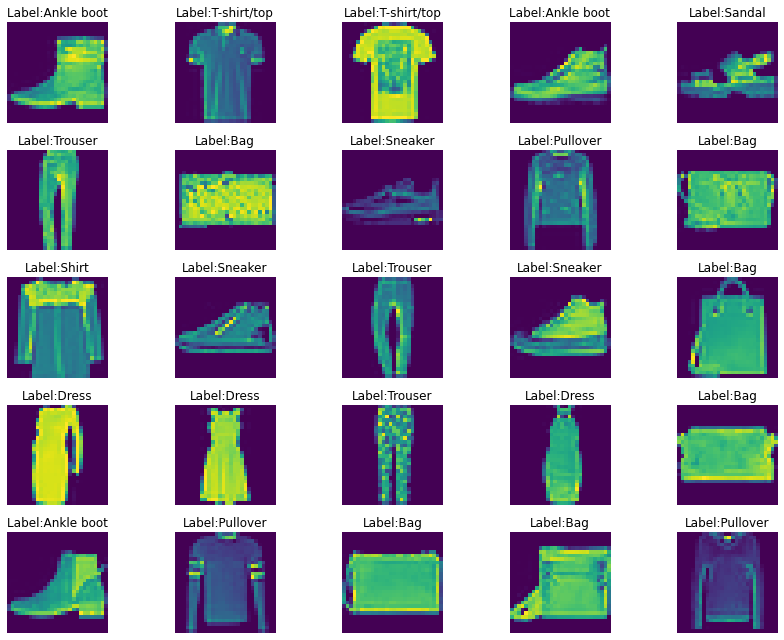

In [9]:
nImg = 5
plt.figure(figsize=(12, 9))
for i in range(nImg*nImg):
    r = np.random.randint(0, len(x_train), 1)
    plt.subplot(nImg, nImg, i+1)
    plt.imshow(x_train[r[0]])
    plt.title('Label:'+type_name[y_train[r[0]]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# scale all to between 0 and 1
x_train_norm = x_train/255
x_test_norm = x_test/255

In [11]:
x_train_norm_exp = np.expand_dims(x_train_norm,axis=3)
x_train_norm_exp.shape
x_test_norm_exp = np.expand_dims(x_test_norm,axis=3)
x_test_norm_exp.shape

(10000, 28, 28, 1)

In [12]:
# one hot encode the output
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
y_train_oh = one_hot.fit_transform(y_train.reshape(-1,1)).toarray()
y_test_oh = one_hot.fit_transform(y_test.reshape(-1,1)).toarray()
y_train_oh

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### function to plot accuracy and loss  
Credit to professor Vakanski for this function  
https://github.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2016%20-%20Convolutional%20Neural%20Networks/Lecture%2016%20-%20Convolutional%20Neural%20Networks%20with%20Keras%20and%20TensorFlow.ipynb


In [13]:
def plot_accuracy_loss(history):
    # plot the accuracy and loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 

### Auto Model Network Generation  
This is where we automatically generate a network based on the params to the Network function

In [14]:
def Network(input_size, blocks=3, filters_max=128, conv_layers=2, dense_layers=2, dense_units_max=128, output_size=2, activation='softmax', lr=1e-4):
    model = Sequential() 
    model.add(Input(input_size))
    for i in range(0,blocks):
        filters = filters_max
        for j in range(0,conv_layers):
            model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
            filters -= filters/2 # halv this number
        # add after conv portion
        if i == blocks -1: # last block
            model.add(GlobalAveragePooling2D())
        else:
            model.add(MaxPooling2D())
    model.add(Flatten())
    
    units = dense_units_max
    for i in range(0,dense_layers):
        model.add(Dense(units, activation='relu'))
        units -= units/2
        
    # output layer
    model.add(Dense(output_size, activation=activation))

    # compile
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model

In [15]:
# our 'quick training' uses 20 epocs with a early stopping patience of 5
epochs_quick = 5
earlystop_quick = 3
# ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)]

callbacks = [EarlyStopping(monitor='val_accuracy', patience=earlystop_quick)]

In [ ]:
# this was a failed attempt at multiprocessing to run several model fit at a time, it failed

#blocks=3, filters_max=128, conv_layers=2, dense_layers=2, dense_units_max=128, output_size=2, activation='softmax', lr=1e-4
#blocks=[1,2,3,4,5]
#filters=[512,256,128,64]
#conv_layers=[1,2,3,4,5]
#dense_layers=[1,2,3,4]
#dense_units=[512,256,128,64,32]
#lr=[1e-3,1e-4,1e-5]
#activation=['softmax','sigmoid']

def multi_fit_model(m,Xtest,ytest,e,b,Xval,yval):
  hist = m.fit(Xtest, ytest, epochs=e, batch_size=b,
              validation_data=(Xval,yval))
  return hist

# brute test all hyperparams to generate diferent models
def model_generation_tester(blocks,filters,conv_layers,dense_layers,dense_units,lr,activation,batch_sizes,epochs=3):
    
    columns=['i','hist','m','b','f','c','d','u','l','a','batch_size','max_val_acc']
    results = []
    exception_models = []
    i=0
    total_runs = len(blocks)*len(filters)*len(conv_layers)*len(dense_layers)*len(dense_units)*len(lr)*len(activation)
    pool = multiprocessing.Pool()
    # pool object with number of element
    pool = multiprocessing.Pool(processes=4)
    for b in blocks:
        for f in filters:
            for c in conv_layers:
                for d in dense_layers:
                    for u in dense_units:
                        for l in lr:
                            for a in activation:
                                for batch_size in batch_sizes:
                                    print(f'RUN {i} of {total_runs}. Completed {i/total_runs:.2f} %')
                                    print(f'--- Blocks:{b} Filters:{f} ConvLayers:{c} DenseLayers:{d} Units:{u} lr:{l} Activation:{a} BatchSize:{batch_size}---')
                                    m = Network(x_train_norm_exp.shape[1:], blocks=b, filters_max=f, conv_layers=c, dense_layers=d, 
                                                dense_units_max=u, output_size=y_train_oh.shape[1], lr=l, activation=a)
                                    #m.summary()
                                    hist = None # for exceptions
                                    try:
                                        inputs = [m, x_train_norm_exp, y_train_oh, epochs, batch_size, x_test_norm_exp, y_test_oh]
                                        outputs = pool.map(multi_fit_model, inputs)
                                        print('outputs',outputs)
                                        #max_val_acc = max(hist.history['val_accuracy'])
                                        #results.append([i,hist,m,b,f,c,d,u,l,a, batch_size,max_val_acc])
                                    except Exception as ex:
                                        exception_models.append([i,hist,m,b,f,c,d,u,l,a, batch_size, 0])
                                        print('Exception:',str(ex)[:200])
                                    i+=1
    return ( pd.DataFrame(results, columns=columns), pd.DataFrame(exception_models, columns=columns))

In [32]:
#blocks=3, filters_max=128, conv_layers=2, dense_layers=2, dense_units_max=128, output_size=2, activation='softmax', lr=1e-4
#blocks=[1,2,3,4,5]
#filters=[512,256,128,64]
#conv_layers=[1,2,3,4,5]
#dense_layers=[1,2,3,4]
#dense_units=[512,256,128,64,32]
#lr=[1e-3,1e-4,1e-5]
#activation=['softmax','sigmoid']

# brute test all hyperparams to generate diferent models
def model_generation_tester(blocks,filters,conv_layers,dense_layers,dense_units,lr,activation,batch_sizes,epochs=3):
    
    columns=['i','hist','m','b','f','c','d','u','l','a','batch_size','max_val_acc']
    results = []
    exception_models = []
    i=0
    total_runs = len(blocks)*len(filters)*len(conv_layers)*len(dense_layers)*len(dense_units)*len(lr)*len(activation)
    for b in blocks:
        for f in filters:
            for c in conv_layers:
                for d in dense_layers:
                    for u in dense_units:
                        for l in lr:
                            for a in activation:
                                for batch_size in batch_sizes:
                                    print(f'RUN {i} of {total_runs}. Completed {i/total_runs:.2f} %')
                                    print(f'--- Blocks:{b} Filters:{f} ConvLayers:{c} DenseLayers:{d} Units:{u} lr:{l} Activation:{a} BatchSize:{batch_size}---')
                                    m = Network(x_train_norm_exp.shape[1:], blocks=b, filters_max=f, conv_layers=c, dense_layers=d, 
                                                dense_units_max=u, output_size=y_train_oh.shape[1], lr=l, activation=a)
                                    #m.summary()
                                    hist = None # for exceptions
                                    try:
                                        hist = m.fit(x_train_norm_exp, y_train_oh, epochs=epochs, batch_size=batch_size,
                                                     validation_data=(x_test_norm_exp,y_test_oh))
                                        max_val_acc = max(hist.history['val_accuracy'])
                                        results.append([i,hist,m,b,f,c,d,u,l,a, batch_size,max_val_acc])
                                    except Exception as ex:
                                        exception_models.append([i,hist,m,b,f,c,d,u,l,a, batch_size, 0])
                                        print('Exception:',str(ex)[:200])
                                    i+=1
    return ( pd.DataFrame(results, columns=columns), pd.DataFrame(exception_models, columns=columns))

In [115]:
# test one option to get baseline
blocks=[3]
filters=[128]
conv_layers=[2]
dense_layers=[2]
dense_units=[64]
lr=[1e-4]
activation=['softmax']
batch_sizes=[64]
basemodel,_ = model_generation_tester(blocks,filters,conv_layers,dense_layers,dense_units,lr,activation,batch_sizes,epochs=2)

RUN 0 of 1. Completed 0.00 %
--- Blocks:3 Filters:128 ConvLayers:2 DenseLayers:2 Units:64 lr:0.0001 Activation:softmax BatchSize:64---
Epoch 1/2
938/938 [==============================] - 13s 13ms/step - loss: 0.2442 - accuracy: 0.4833 - val_loss: 0.1541 - val_accuracy: 0.6769
Epoch 2/2
938/938 [==============================] - 12s 13ms/step - loss: 0.1277 - accuracy: 0.7319 - val_loss: 0.1168 - val_accuracy: 0.7538


In [116]:
basemodel

,i,hist,m,b,f,c,d,u,l,a,batch_size,max_val_acc
0,0,<keras.callbacks.History object at 0x7f143e5c3...,<keras.engine.sequential.Sequential object at ...,3,128,2,2,64,0.0001,softmax,64,0.7538


In [35]:
# test many options 
blocks=[1,2,3,4,5]
filters=[128,64]
conv_layers=[1,2,3]
dense_layers=[1,2,3]
dense_units=[128,64,32]
lr=[1e-4]
activation=['softmax']
batch_sizes=[64]

results,exceptions = model_generation_tester(blocks,filters,conv_layers,dense_layers,dense_units,lr,activation,batch_sizes,epochs=2)

RUN 0 of 270. Completed 0.00 %
--- Blocks:1 Filters:128 ConvLayers:1 DenseLayers:1 Units:128 lr:0.0001 Activation:softmax BatchSize:64---
Epoch 1/2
938/938 [==============================] - 5s 5ms/step - loss: 0.4063 - accuracy: 0.0985 - val_loss: 0.3301 - val_accuracy: 0.0904
Epoch 2/2
938/938 [==============================] - 5s 5ms/step - loss: 0.3139 - accuracy: 0.1787 - val_loss: 0.2981 - val_accuracy: 0.2484
RUN 1 of 270. Completed 0.00 %
--- Blocks:1 Filters:128 ConvLayers:1 DenseLayers:1 Units:64 lr:0.0001 Activation:softmax BatchSize:64---
Epoch 1/2
938/938 [==============================] - 5s 5ms/step - loss: 0.4334 - accuracy: 0.1009 - val_loss: 0.3347 - val_accuracy: 0.1002
Epoch 2/2
938/938 [==============================] - 5s 5ms/step - loss: 0.3241 - accuracy: 0.1434 - val_loss: 0.3112 - val_accuracy: 0.1769
RUN 2 of 270. Completed 0.01 %
--- Blocks:1 Filters:128 ConvLayers:1 DenseLayers:1 Units:32 lr:0.0001 Activation:softmax BatchSize:64---
Epoch 1/2
938/938 [=====

In [38]:
results.columns

Index(['i', 'hist', 'm', 'b', 'f', 'c', 'd', 'u', 'l', 'a', 'batch_size',
       'max_val_acc'],
      dtype='object')

In [42]:
results.head()

,i,hist,m,b,f,c,d,u,l,a,batch_size,max_val_acc
0,0,<keras.callbacks.History object at 0x7f1969812...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,128,0.0001,softmax,64,0.2484
1,1,<keras.callbacks.History object at 0x7f196997d...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,64,0.0001,softmax,64,0.1769
2,2,<keras.callbacks.History object at 0x7f1969c4f...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,32,0.0001,softmax,64,0.1000
3,3,<keras.callbacks.History object at 0x7f1ab43dc...,<keras.engine.sequential.Sequential object at ...,1,128,1,2,128,0.0001,softmax,64,0.2771
4,4,<keras.callbacks.History object at 0x7f1b63452...,<keras.engine.sequential.Sequential object at ...,1,128,1,2,64,0.0001,softmax,64,0.2311


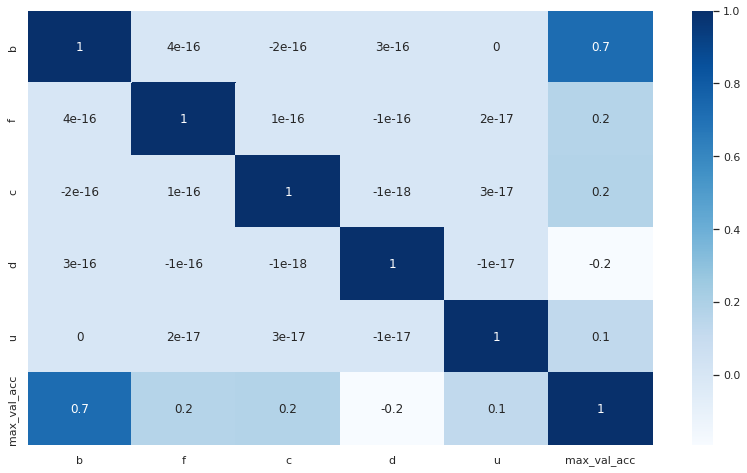

In [47]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = results[['b', 'f', 'c', 'd', 'u','max_val_acc']].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [51]:
# lets look at the top 10
results.sort_values(by='max_val_acc', ascending=False).head(10)

,i,hist,m,b,f,c,d,u,l,a,batch_size,max_val_acc
183,183,<keras.callbacks.History object at 0x7f171bf0e...,<keras.engine.sequential.Sequential object at ...,4,128,3,2,128,0.0001,softmax,64,0.8447
180,180,<keras.callbacks.History object at 0x7f175e42b...,<keras.engine.sequential.Sequential object at ...,4,128,3,1,128,0.0001,softmax,64,0.8436
184,184,<keras.callbacks.History object at 0x7f16f7a3b...,<keras.engine.sequential.Sequential object at ...,4,128,3,2,64,0.0001,softmax,64,0.8331
181,181,<keras.callbacks.History object at 0x7f171c411...,<keras.engine.sequential.Sequential object at ...,4,128,3,1,64,0.0001,softmax,64,0.8256
171,171,<keras.callbacks.History object at 0x7f173cc8c...,<keras.engine.sequential.Sequential object at ...,4,128,2,1,128,0.0001,softmax,64,0.8223
182,182,<keras.callbacks.History object at 0x7f171c1e7...,<keras.engine.sequential.Sequential object at ...,4,128,3,1,32,0.0001,softmax,64,0.8192
172,172,<keras.callbacks.History object at 0x7f173ca3a...,<keras.engine.sequential.Sequential object at ...,4,128,2,1,64,0.0001,softmax,64,0.8161
185,185,<keras.callbacks.History object at 0x7f16f7758...,<keras.engine.sequential.Sequential object at ...,4,128,3,2,32,0.0001,softmax,64,0.8158
174,174,<keras.callbacks.History object at 0x7f173c656...,<keras.engine.sequential.Sequential object at ...,4,128,2,2,128,0.0001,softmax,64,0.8156
175,175,<keras.callbacks.History object at 0x7f173a45a...,<keras.engine.sequential.Sequential object at ...,4,128,2,2,64,0.0001,softmax,64,0.8151


In [52]:
# lets look at the bottom 10
results.sort_values(by='max_val_acc', ascending=True).head(10)

,i,hist,m,b,f,c,d,u,l,a,batch_size,max_val_acc
240,240,<keras.callbacks.History object at 0x7f14ed279...,<keras.engine.sequential.Sequential object at ...,5,128,3,3,128,0.0001,softmax,64,0.1000
35,35,<keras.callbacks.History object at 0x7f19642a1...,<keras.engine.sequential.Sequential object at ...,1,64,1,3,32,0.0001,softmax,64,0.1000
267,267,<keras.callbacks.History object at 0x7f148b1c7...,<keras.engine.sequential.Sequential object at ...,5,64,3,3,128,0.0001,softmax,64,0.1000
89,89,<keras.callbacks.History object at 0x7f1834e38...,<keras.engine.sequential.Sequential object at ...,2,64,1,3,32,0.0001,softmax,64,0.1000
5,5,<keras.callbacks.History object at 0x7f1b63597...,<keras.engine.sequential.Sequential object at ...,1,128,1,2,32,0.0001,softmax,64,0.1000
32,32,<keras.callbacks.History object at 0x7f196b222...,<keras.engine.sequential.Sequential object at ...,1,64,1,2,32,0.0001,softmax,64,0.1000
2,2,<keras.callbacks.History object at 0x7f1969c4f...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,32,0.0001,softmax,64,0.1000
161,161,<keras.callbacks.History object at 0x7f174a735...,<keras.engine.sequential.Sequential object at ...,3,64,3,3,32,0.0001,softmax,64,0.1000
29,29,<keras.callbacks.History object at 0x7f1aea294...,<keras.engine.sequential.Sequential object at ...,1,64,1,1,32,0.0001,softmax,64,0.1078
31,31,<keras.callbacks.History object at 0x7f196b323...,<keras.engine.sequential.Sequential object at ...,1,64,1,2,64,0.0001,softmax,64,0.1136


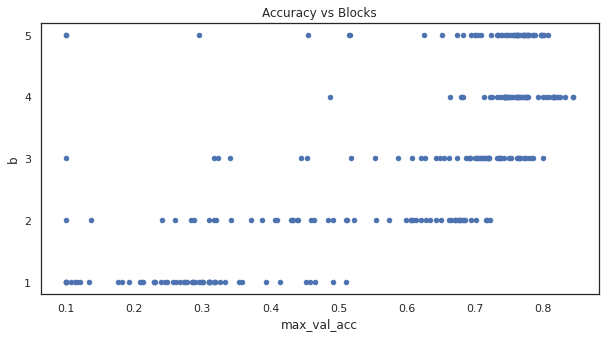

In [77]:
results[['b','max_val_acc']].plot(x='max_val_acc', y='b',kind='scatter', figsize=(10,5), title='Accuracy vs Blocks', legend=True, yticks=[1,2,3,4,5])

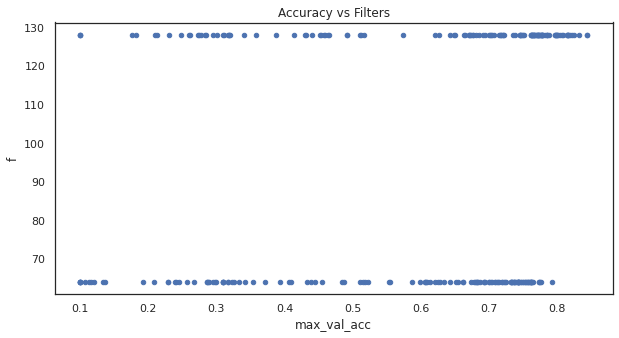

In [78]:
results[['f','max_val_acc']].plot(x='max_val_acc', y='f',kind='scatter', figsize=(10,5), title='Accuracy vs Filters', legend=True)

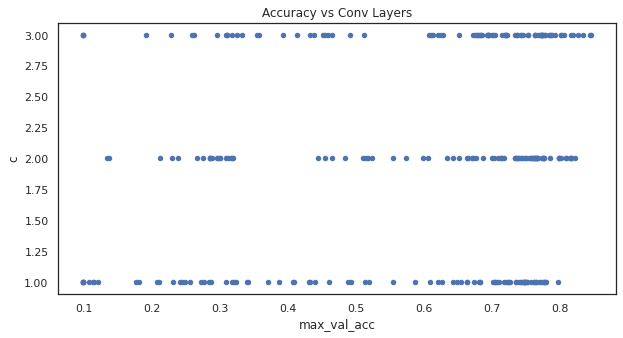

In [76]:
results[['c','max_val_acc']].plot(x='max_val_acc', y='c',kind='scatter', figsize=(10,5), title='Accuracy vs Conv Layers', legend=True)

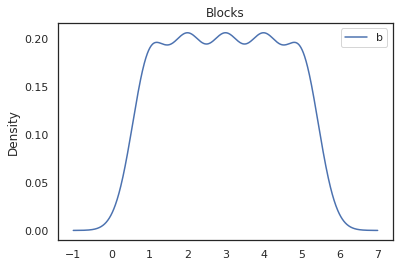

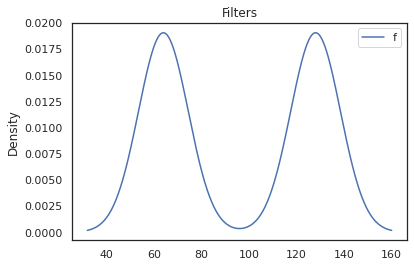

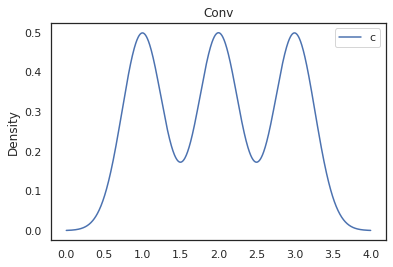

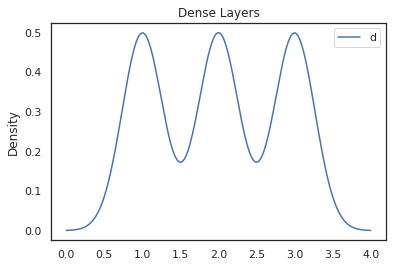

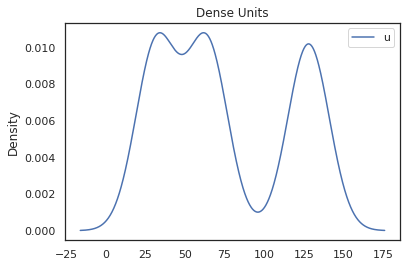

In [93]:
titles= ['Blocks','Filters','Conv','Dense Layers','Dense Units']
i=0
for p in ['b', 'f', 'c', 'd', 'u']:
  results[[p,'max_val_acc']].plot(x='max_val_acc',kind='density', legend=True,title=titles[i])
  i = i+1

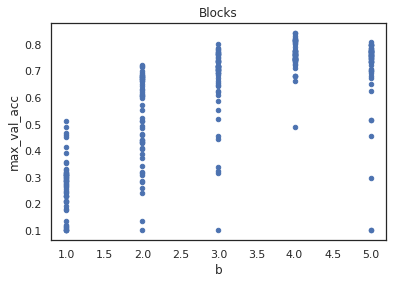

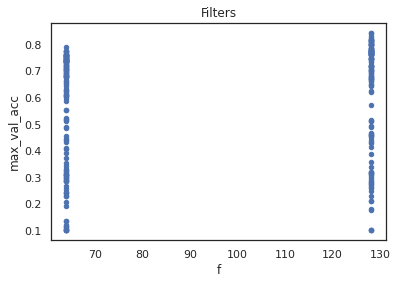

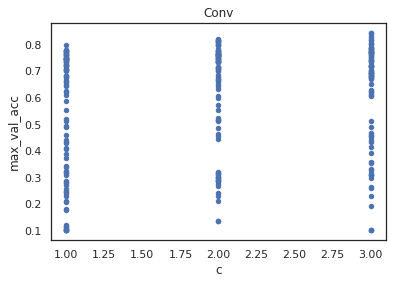

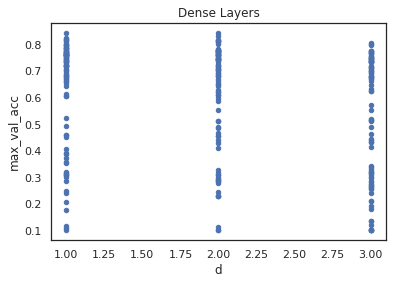

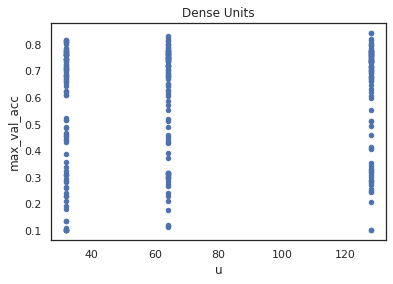

In [96]:
titles= ['Blocks','Filters','Conv','Dense Layers','Dense Units']
i=0
for p in ['b', 'f', 'c', 'd', 'u']:
  results[[p,'max_val_acc']].plot(x=p,y='max_val_acc',kind='scatter', legend=True,title=titles[i])
  i = i+1

In [120]:
# our full training for top 10 and bottom 10 and baseline, for full training
epochs_full = 200
earlystop_full = 10
batch_size_full = 64
callbacks_full = [EarlyStopping(monitor='val_accuracy', patience=earlystop_full), 
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)]

In [121]:
top10 = results.sort_values(by='max_val_acc', ascending=False).head(10).copy(deep=True)
bot10 = results.sort_values(by='max_val_acc', ascending=True).head(10).copy(deep=True)

In [105]:
results.head()

,i,hist,m,b,f,c,d,u,l,a,batch_size,max_val_acc
0,0,<keras.callbacks.History object at 0x7f1969812...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,128,0.0001,softmax,64,0.2484
1,1,<keras.callbacks.History object at 0x7f196997d...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,64,0.0001,softmax,64,0.1769
2,2,<keras.callbacks.History object at 0x7f1969c4f...,<keras.engine.sequential.Sequential object at ...,1,128,1,1,32,0.0001,softmax,64,0.1000
3,3,<keras.callbacks.History object at 0x7f1ab43dc...,<keras.engine.sequential.Sequential object at ...,1,128,1,2,128,0.0001,softmax,64,0.2771
4,4,<keras.callbacks.History object at 0x7f1b63452...,<keras.engine.sequential.Sequential object at ...,1,128,1,2,64,0.0001,softmax,64,0.2311


In [118]:
# make a copy in case we need to retrain
basecopy = basemodel.copy(deep=True)
m = basecopy['m'][0]
hist_baseline = m.fit(x_train_norm_exp, y_train_oh, epochs=epochs_full, batch_size=batch_size_full,
                                                     validation_data=(x_test_norm_exp,y_test_oh), 
                                                    callbacks=callbacks_full)

Epoch 1/200
938/938 [==============================] - 12s 13ms/step - loss: 0.1107 - accuracy: 0.7671 - val_loss: 0.1087 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 2/200
938/938 [==============================] - 12s 13ms/step - loss: 0.1006 - accuracy: 0.7913 - val_loss: 0.0977 - val_accuracy: 0.7977 - lr: 1.0000e-04
Epoch 3/200
938/938 [==============================] - 12s 13ms/step - loss: 0.0936 - accuracy: 0.8106 - val_loss: 0.0979 - val_accuracy: 0.8033 - lr: 1.0000e-04
Epoch 4/200
938/938 [==============================] - 12s 13ms/step - loss: 0.0888 - accuracy: 0.8206 - val_loss: 0.0911 - val_accuracy: 0.8179 - lr: 1.0000e-04
Epoch 5/200
938/938 [==============================] - 12s 13ms/step - loss: 0.0838 - accuracy: 0.8327 - val_loss: 0.0858 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 6/200
938/938 [==============================] - 12s 13ms/step - loss: 0.0805 - accuracy: 0.8389 - val_loss: 0.0796 - val_accuracy: 0.8419 - lr: 1.0000e-04
Epoch 7/200
938/938 [=======

In [122]:
top10_hist = []
for i, r in top10.iterrows():
  prev = r['hist'].history['val_accuracy'][-1]
  print(f'Full Training #:{i} previous best validation acc: {prev}')
  m = r['m'] # grab model
  hist = m.fit(x_train_norm_exp, y_train_oh, epochs=epochs_full, batch_size=batch_size_full,
                                                     validation_data=(x_test_norm_exp,y_test_oh), 
                                                    callbacks=callbacks_full)
  top10_hist.append(hist)


Full Training #:183 previous best validation acc: 0.8446999788284302
Epoch 1/200
938/938 [==============================] - 15s 16ms/step - loss: 0.0272 - accuracy: 0.9472 - val_loss: 0.0461 - val_accuracy: 0.9159 - lr: 1.0000e-04
Epoch 2/200
938/938 [==============================] - 14s 15ms/step - loss: 0.0259 - accuracy: 0.9503 - val_loss: 0.0486 - val_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 3/200
938/938 [==============================] - 14s 15ms/step - loss: 0.0246 - accuracy: 0.9530 - val_loss: 0.0449 - val_accuracy: 0.9173 - lr: 1.0000e-04
Epoch 4/200
938/938 [==============================] - 14s 15ms/step - loss: 0.0233 - accuracy: 0.9551 - val_loss: 0.0500 - val_accuracy: 0.9118 - lr: 1.0000e-04
Epoch 5/200
938/938 [==============================] - 14s 15ms/step - loss: 0.0222 - accuracy: 0.9578 - val_loss: 0.0523 - val_accuracy: 0.9094 - lr: 1.0000e-04
Epoch 6/200
938/938 [==============================] - 14s 15ms/step - loss: 0.0212 - accuracy: 0.9601 - val_loss: 0.0540

In [133]:
# list the new accuracy scores
top10acc = []
for n in range(len(top10_hist)):
  maxacc = max(top10_hist[n].history['val_accuracy'])
  print(f'Index: {n} Max Validation Accuracy: {maxacc:.4f}')
  top10acc.append(maxacc)
(pd.DataFrame(top10acc)).to_csv('top10acc.csv')

Index: 0 Max Validation Accuracy: 0.9190
Index: 1 Max Validation Accuracy: 0.9156
Index: 2 Max Validation Accuracy: 0.9210
Index: 3 Max Validation Accuracy: 0.9227
Index: 4 Max Validation Accuracy: 0.9279
Index: 5 Max Validation Accuracy: 0.9147
Index: 6 Max Validation Accuracy: 0.9227
Index: 7 Max Validation Accuracy: 0.9240
Index: 8 Max Validation Accuracy: 0.9240
Index: 9 Max Validation Accuracy: 0.9233


In [138]:
bot10_hist = []
num = 1
starttime = datetime.datetime.now()
for i, r in bot10.iterrows():
  prev = r['hist'].history['val_accuracy'][-1]
  print(f'Elapsed: {datetime.datetime.now()-starttime}')
  print(f'Full Training #:{i} previous best validation acc: {prev} number: {num}')
  num += 1
  m = r['m'] # grab model
  hist = m.fit(x_train_norm_exp, y_train_oh, epochs=epochs_full, batch_size=batch_size_full,
                                                     validation_data=(x_test_norm_exp,y_test_oh), 
                                                    callbacks=callbacks_full)
  bot10_hist.append(hist)
  print(f'Elapsed: {datetime.datetime.now()-starttime}')

# show/save the results
bot10acc = []
for n in range(len(bot10_hist)):
  maxacc = max(bot10_hist[n].history['val_accuracy'])
  print(f'Index: {n} Max Validation Accuracy: {maxacc:.4f}')
  bot10acc.append(maxacc)
(pd.DataFrame(bot10acc)).to_csv('bot10acc.csv')

Elapsed: 0:00:00.001158
Full Training #:240 previous best validation acc: 0.10000000149011612 number: 1
Epoch 1/200
938/938 [==============================] - 15s 16ms/step - loss: 0.3253 - accuracy: 0.1014 - val_loss: 0.3254 - val_accuracy: 0.1021 - lr: 1.0000e-04
Epoch 2/200
938/938 [==============================] - 15s 16ms/step - loss: 0.2229 - accuracy: 0.4280 - val_loss: 0.1322 - val_accuracy: 0.7121 - lr: 1.0000e-04
Epoch 3/200
938/938 [==============================] - 15s 16ms/step - loss: 0.1056 - accuracy: 0.7659 - val_loss: 0.1021 - val_accuracy: 0.7719 - lr: 1.0000e-04
Epoch 4/200
938/938 [==============================] - 15s 16ms/step - loss: 0.0918 - accuracy: 0.7992 - val_loss: 0.0901 - val_accuracy: 0.8033 - lr: 1.0000e-04
Epoch 5/200
938/938 [==============================] - 15s 16ms/step - loss: 0.0818 - accuracy: 0.8244 - val_loss: 0.0804 - val_accuracy: 0.8252 - lr: 1.0000e-04
Epoch 6/200
938/938 [==============================] - 15s 16ms/step - loss: 0.0753 - 

In [139]:
# list the new accuracy scores
bot10acc = []
for n in range(len(bot10_hist)):
  maxacc = max(bot10_hist[n].history['val_accuracy'])
  print(f'Index: {n} Max Validation Accuracy: {maxacc:.4f}')
  bot10acc.append(maxacc)
(pd.DataFrame(bot10acc)).to_csv('bot10acc.csv')

Index: 0 Max Validation Accuracy: 0.9217
Index: 1 Max Validation Accuracy: 0.6608
Index: 2 Max Validation Accuracy: 0.9255
Index: 3 Max Validation Accuracy: 0.1000
Index: 4 Max Validation Accuracy: 0.7141
Index: 5 Max Validation Accuracy: 0.6972
Index: 6 Max Validation Accuracy: 0.7114
Index: 7 Max Validation Accuracy: 0.9168
Index: 8 Max Validation Accuracy: 0.7053
Index: 9 Max Validation Accuracy: 0.7318


In [140]:
bot10acc.sort()

In [141]:
bot10acc.sort()